# Pneumonia Detection from Chest X-Ray Images

This project uses deep learning to automatically detect pneumonia from chest X-ray images. We implement an **ensemble learning approach** that combines multiple models to achieve better performance than individual models alone.

## 1. Data Extraction

In [ ]:
import os
import zipfile

if not os.path.exists('chest_xray'):
    with zipfile.ZipFile('ChestDataset.zip', 'r') as z:
        z.extractall()
    print("Dataset extracted successfully.")
else:
    print("Dataset already extracted.")

## 2. Installing Required Libraries

In [ ]:
%pip install tensorflow numpy pandas matplotlib seaborn scikit-learn

## 3. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Average, Concatenate
from tensorflow.keras.applications import ResNet50, DenseNet121, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## 4. Data Preparation

In [ ]:
img_size = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,  
    zoom_range=0.2, 
    horizontal_flip=True,
    vertical_flip=False, 
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]  
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "chest_xray/chest_xray/train",
    batch_size=24, 
    target_size=(img_size, img_size),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

valid_generator = valid_datagen.flow_from_directory(
    "chest_xray/chest_xray/val",
    batch_size=24,
    target_size=(img_size, img_size),
    class_mode='categorical',
    shuffle=False,
    seed=42,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/test",
    batch_size=24,
    target_size=(img_size, img_size),
    class_mode='categorical',
    shuffle=False,
    seed=42,
    color_mode='rgb'
)

class_name = test_generator.class_indices
print("Class labels:", class_name)

In [ ]:
class_counts = np.bincount(train_generator.classes)
total_samples = np.sum(class_counts)
n_classes = len(class_counts)

class_weights = {i: total_samples / (n_classes * count) for i, count in enumerate(class_counts)}
print("\nClass weights for handling imbalance:")
print(class_weights)

## 5. Data Exploration

In [ ]:
pneumonia = [f for f in os.listdir("chest_xray/chest_xray/train/PNEUMONIA") if not f.startswith('.')]
pneumonia_dir = "chest_xray/chest_xray/train/PNEUMONIA"
normal = [f for f in os.listdir("chest_xray/chest_xray/train/NORMAL") if not f.startswith('.')]
normal_dir = "chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))
for i in range(min(9, len(pneumonia))):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()
plt.suptitle("Examples of Pneumonia X-rays", fontsize=22)
plt.subplots_adjust(top=0.9)
plt.show()

plt.figure(figsize=(20, 10))
for i in range(min(9, len(normal))):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()
plt.suptitle("Examples of Normal X-rays", fontsize=22)
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
listx = []
for i in train_generator.classes:
    if i == 0:
        listx.append("Pneumonia")
    else:
        listx.append("Normal")

plt.figure(figsize=(10, 6))
ax = sns.countplot(listx)
plt.title("Class Distribution in Training Set", fontsize=16)
plt.xlabel("Diagnosis")
plt.ylabel("Number of Images")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.show()

## 6. Ensemble Learning for Pneumonia Detection

Ensemble learning combines predictions from multiple models to improve overall performance. In this project, we'll create an ensemble of three powerful CNN architectures: ResNet50, DenseNet121, and VGG16.

### 6.1 Creating ResNet50 Model with Fine-tuning

In [ ]:
es = EarlyStopping(
    monitor="val_loss",
    verbose=1,
    mode="min",
    patience=8, 
    restore_best_weights=True
)

lrr = ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=4,
    verbose=1,
    factor=0.6, 
    min_lr=0.000005
)

def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 3:
        return initial_lr
    elif epoch < 6:
        return initial_lr * 0.5
    elif epoch < 9:
        return initial_lr * 0.25
    else:
        return initial_lr * 0.1

lr_scheduler = LearningRateScheduler(lr_schedule)

def create_resnet_model():
    base_model = ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    output = Dense(2, activation='softmax')(x)
    
    model = Model(base_model.input, output)
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model, base_model

resnet_model, resnet_base = create_resnet_model()
print("ResNet50 model created.")
resnet_model.summary()

In [ ]:
print("Training ResNet50 model (Phase 1)...")
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=8,
    callbacks=[es, lrr, lr_scheduler],
    validation_data=valid_generator,
    class_weight=class_weights
)

print("\nPhase 2: Fine-tuning ResNet50 model...")

for layer in resnet_base.layers[-20:]: 
    layer.trainable = True
    
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.00005), 
    metrics=['accuracy']
)

resnet_history_ft = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=6,
    callbacks=[es, lrr],
    validation_data=valid_generator,
    class_weight=class_weights
)

if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
resnet_model.save("model_weights/resnet_model_ft.h5")
print("ResNet50 model trained, fine-tuned and saved.")

218/218 ━━━━━━━━━━━━━━━━━━━━ 195s 891ms/step - accuracy: 0.7936 - loss: 0.7888 - val_accuracy: 0.6875 - val_loss: 0.8416 - learning_rate: 0.0010
Epoch 3/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 195s 891ms/step - accuracy: 0.7936 - loss: 0.7888 - val_accuracy: 0.6875 - val_loss: 0.8416 - learning_rate: 0.0010
Epoch 3/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 181s 829ms/step - accuracy: 0.8156 - loss: 0.7016 - val_accuracy: 0.6875 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 4/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 181s 829ms/step - accuracy: 0.8156 - loss: 0.7016 - val_accuracy: 0.6875 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 4/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 197s 902ms/step - accuracy: 0.8446 - loss: 0.6152 - val_accuracy: 0.5000 - val_loss: 6.8879 - learning_rate: 5.0000e-04
Epoch 5/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 197s 902ms/step - accuracy: 0.8446 - loss: 0.6152 - val_accuracy: 0.5000 - val_loss: 6.8879 - learning_rate: 5.0000e-04
Epoch 5/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 195s 894ms/step - accuracy: 0.834

ResNet50 model trained, fine-tuned and saved.


### 6.2 Creating DenseNet121 Model with Fine-tuning

In [ ]:
def create_densenet_model():
    densenet_base = DenseNet121(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    for layer in densenet_base.layers:
        layer.trainable = False
        
    x = densenet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(384, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(densenet_base.input, output)
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model, densenet_base

densenet_model, densenet_base = create_densenet_model()
print("DenseNet121 model created.")
densenet_model.summary()

DenseNet121 model created.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,125,378 (31.00 MB)

 Trainable params: 1,085,570 (4.14 MB)

 Non-trainable params: 7,039,808 (26.85 MB)

In [ ]:
print("Training DenseNet121 model (Phase 1)...")
densenet_history = densenet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=8,
    callbacks=[es, lrr, lr_scheduler],
    validation_data=valid_generator,
    class_weight=class_weights
)

print("\nPhase 2: Fine-tuning DenseNet121 model...")

for layer in densenet_base.layers[-30:]:  
    layer.trainable = True
    
densenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.00005),  
    metrics=['accuracy']
)

densenet_history_ft = densenet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=6,
    callbacks=[es, lrr],
    validation_data=valid_generator,
    class_weight=class_weights
)

densenet_model.save("model_weights/densenet_model_ft.h5")
print("DenseNet121 model trained, fine-tuned and saved.")

Training DenseNet121 model (Phase 1)...
Epoch 1/8
Epoch 1/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 152s 660ms/step - accuracy: 0.8035 - loss: 1.0208 - val_accuracy: 0.8750 - val_loss: 0.7906 - learning_rate: 0.0010
Epoch 2/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 152s 660ms/step - accuracy: 0.8035 - loss: 1.0208 - val_accuracy: 0.8750 - val_loss: 0.7906 - learning_rate: 0.0010
Epoch 2/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 140s 643ms/step - accuracy: 0.9033 - loss: 0.6392 - val_accuracy: 0.8750 - val_loss: 0.5603 - learning_rate: 0.0010
Epoch 3/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 140s 643ms/step - accuracy: 0.9033 - loss: 0.6392 - val_accuracy: 0.8750 - val_loss: 0.5603 - learning_rate: 0.0010
Epoch 3/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 140s 641ms/step - accuracy: 0.9044 - loss: 0.5656 - val_accuracy: 0.8750 - val_loss: 0.5969 - learning_rate: 0.0010
Epoch 4/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 140s 641ms/step - accuracy: 0.9044 - loss: 0.5656 - val_accuracy: 0.8750 - val_loss: 0.5969 - learning_rate: 0.0010
Epoch 4/8
218/218 ━━

DenseNet121 model trained, fine-tuned and saved.


### 6.3 Creating VGG16 Model with Fine-tuning

Adding a third model (VGG16) to increase the diversity of our ensemble.

In [ ]:
def create_vgg_model():
    vgg_base = VGG16(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    for layer in vgg_base.layers:
        layer.trainable = False
        
    x = vgg_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)
    
    model = Model(vgg_base.input, output)
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model, vgg_base

vgg_model, vgg_base = create_vgg_model()
print("VGG16 model created.")
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
VGG16 model created.
VGG16 model created.


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │         1,02

 Total params: 14,980,418 (57.15 MB)

 Trainable params: 264,706 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
print("Training VGG16 model (Phase 1)...")
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=8,
    callbacks=[es, lrr, lr_scheduler],
    validation_data=valid_generator,
    class_weight=class_weights
)

print("\nPhase 2: Fine-tuning VGG16 model...")

for layer in vgg_base.layers[-8:]:  
    layer.trainable = True
    
vgg_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.00005),  
    metrics=['accuracy']
)

vgg_history_ft = vgg_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=6,
    callbacks=[es, lrr],
    validation_data=valid_generator,
    class_weight=class_weights
)

vgg_model.save("model_weights/vgg_model_ft.h5")
print("VGG16 model trained, fine-tuned and saved.")

Training VGG16 model (Phase 1)...
Epoch 1/8
Epoch 1/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.8043 - loss: 0.5857 - val_accuracy: 0.5000 - val_loss: 0.9877 - learning_rate: 0.0010
Epoch 2/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.8043 - loss: 0.5857 - val_accuracy: 0.5000 - val_loss: 0.9877 - learning_rate: 0.0010
Epoch 2/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8919 - loss: 0.3711 - val_accuracy: 0.8125 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 3/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8919 - loss: 0.3711 - val_accuracy: 0.8125 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 3/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.9028 - loss: 0.3354 - val_accuracy: 0.9375 - val_loss: 0.4190 - learning_rate: 0.0010
Epoch 4/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.9028 - loss: 0.3354 - val_accuracy: 0.9375 - val_loss: 0.4190 - learning_rate: 0.0010
Epoch 4/8
218/218 ━━━━━━━━━━━━━━━━━━━━ 346s 

VGG16 model trained, fine-tuned and saved.


### 6.4 Creating the Weighted Ensemble Model

Now we'll combine all three models into a weighted ensemble to improve overall performance.

In [ ]:
def create_weighted_ensemble_model():
    try:
        model1 = load_model("model_weights/resnet_model_ft.h5")
        model2 = load_model("model_weights/densenet_model_ft.h5")
        model3 = load_model("model_weights/vgg_model_ft.h5")
        print("Models loaded from files.")
    except:
        model1 = resnet_model
        model2 = densenet_model
        model3 = vgg_model
        print("Using models from memory.")
    
    valid_generator.reset()
    resnet_val_score = model1.evaluate(valid_generator)
    valid_generator.reset()
    densenet_val_score = model2.evaluate(valid_generator)
    valid_generator.reset()
    vgg_val_score = model3.evaluate(valid_generator)
    
    resnet_acc = resnet_val_score[1]
    densenet_acc = densenet_val_score[1]
    vgg_acc = vgg_val_score[1]
    
    total = resnet_acc + densenet_acc + vgg_acc
    w1 = resnet_acc / total
    w2 = densenet_acc / total
    w3 = vgg_acc / total
    
    print(f"Ensemble weights: ResNet={w1:.4f}, DenseNet={w2:.4f}, VGG={w3:.4f}")
    
    input_layer = Input(shape=(224, 224, 3))
    
    model1_out = model1(input_layer)
    model2_out = model2(input_layer)
    model3_out = model3(input_layer)
    
    weighted_outputs = [
        tf.keras.layers.Lambda(lambda x: x * w1)(model1_out),
        tf.keras.layers.Lambda(lambda x: x * w2)(model2_out),
        tf.keras.layers.Lambda(lambda x: x * w3)(model3_out)
    ]
    
    ensemble_output = tf.keras.layers.Add()(weighted_outputs)
    
    ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)
    
    ensemble_model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.00001),
        metrics=['accuracy']
    )
    
    return ensemble_model

ensemble_model = create_weighted_ensemble_model()

ensemble_model.save("model_weights/weighted_ensemble_model.h5")
print("Weighted ensemble model created and saved.")

NameError: name 'resnet_model' is not defined

## 7. Model Evaluation

Let's evaluate our improved ensemble model on the test dataset.

In [ ]:
test_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/test",
    batch_size=16,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    seed=42,
    color_mode='rgb'
)

print("\nEvaluating individual models:")
test_generator.reset()
resnet_eval = resnet_model.evaluate(test_generator)
test_generator.reset()
densenet_eval = densenet_model.evaluate(test_generator)
test_generator.reset()
vgg_eval = vgg_model.evaluate(test_generator)
test_generator.reset()
ensemble_eval = ensemble_model.evaluate(test_generator)

print("\nModel Performance:")
print(f"ResNet50 Test Accuracy: {resnet_eval[1]:.4f} ({resnet_eval[1]*100:.2f}%)")
print(f"DenseNet121 Test Accuracy: {densenet_eval[1]:.4f} ({densenet_eval[1]*100:.2f}%)")
print(f"VGG16 Test Accuracy: {vgg_eval[1]:.4f} ({vgg_eval[1]*100:.2f}%)")
print(f"Weighted Ensemble Model Test Accuracy: {ensemble_eval[1]:.4f} ({ensemble_eval[1]*100:.2f}%)")

Found 624 images belonging to 2 classes.

Evaluating individual models:
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - accuracy: 0.8372 - loss: 0.5729
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - accuracy: 0.9108 - loss: 0.4356
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9124 - loss: 0.3066
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9193 - loss: 0.6028

Model Performance:
ResNet50 Test Accuracy: 0.8429 (84.29%)
DenseNet121 Test Accuracy: 0.9199 (91.99%)
VGG16 Test Accuracy: 0.9327 (93.27%)
Weighted Ensemble Model Test Accuracy: 0.9375 (93.75%)


In [ ]:
test_generator.reset()
ensemble_preds = ensemble_model.predict(test_generator)
ensemble_classes = np.argmax(ensemble_preds, axis=1)
y_true = test_generator.classes

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

precision = precision_score(y_true, ensemble_classes)
recall = recall_score(y_true, ensemble_classes)
f1 = f1_score(y_true, ensemble_classes)
auc = roc_auc_score(test_generator.classes, ensemble_preds[:, 1])

print(f"\nEnsemble Model Advanced Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step

Ensemble Model Advanced Metrics:
Precision: 0.9312
Recall/Sensitivity: 0.9718
F1 Score: 0.9511
ROC-AUC: 0.9649


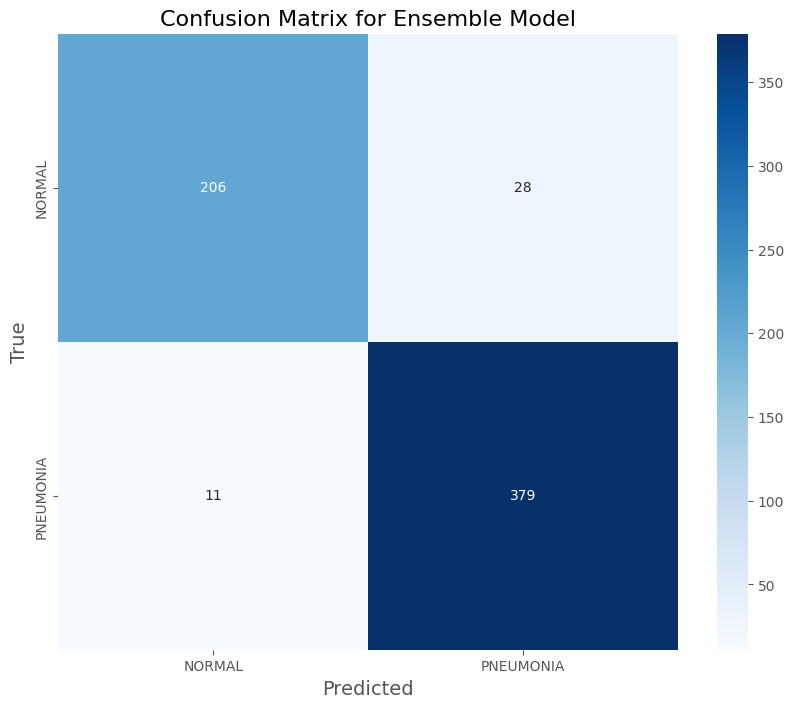


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.88      0.91       234
   PNEUMONIA       0.93      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



In [ ]:
cm = confusion_matrix(y_true, ensemble_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_name.keys()), 
            yticklabels=list(class_name.keys()))
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix for Ensemble Model', fontsize=16)
plt.show()

print('\nClassification Report:')
print(classification_report(y_true, ensemble_classes, target_names=list(class_name.keys())))

## 8. Model Comparison

Compare the performance of individual models vs. the ensemble model.


Final Model Comparison:
               Model  Accuracy (%)
0           ResNet50     84.294873
1        DenseNet121     91.987181
2              VGG16     93.269229
3  Weighted Ensemble     93.750000


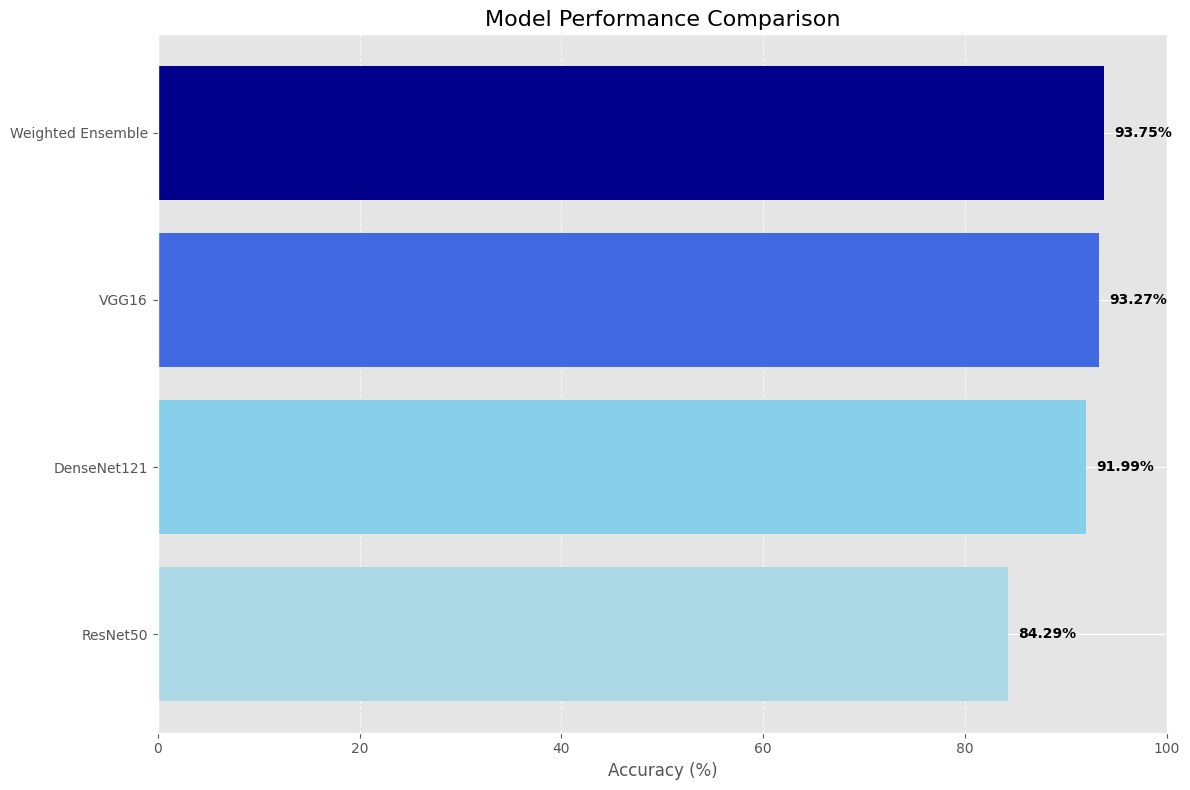

In [ ]:
all_models = ['ResNet50', 'DenseNet121', 'VGG16', 'Weighted Ensemble']
accuracy = [resnet_eval[1], densenet_eval[1], vgg_eval[1], ensemble_eval[1]]
accuracy_percent = [acc*100 for acc in accuracy]

comparison_df = pd.DataFrame({
    'Model': all_models,
    'Accuracy (%)': accuracy_percent
})

print("\nFinal Model Comparison:")
print(comparison_df)

plt.figure(figsize=(12, 8))
bars = plt.barh(all_models, accuracy_percent, color=['lightblue', 'skyblue', 'royalblue', 'darkblue'])

plt.xlabel('Accuracy (%)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16)
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{accuracy_percent[i]:.2f}%", va='center', fontweight='bold')

plt.tight_layout()
plt.show()